Net: GoogLeNet https://github.com/BVLC/caffe/blob/master/models/bvlc_googlenet/train_val.prototxt <br>
source: https://github.com/google/deepdream

In [20]:
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format
import matplotlib.pyplot as plt
import sys
%matplotlib inline

caffe_root = '/works/caffe/'
#sys.path.append(caffe_root + 'python')
import caffe

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    return Image(data=f.getvalue())
    
    
# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']


def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])


def objective_L2(dst):
    dst.diff[:] = dst.data 

    
def make_step(net, step_size=1.5, end='inception_4c/output', jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''
    # input image is stored in Net's 'data' blob
    src = net.blobs['data'] 
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    # apply jitter shift
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) 
            
    net.forward(end=end)
    # specify the optimization objective
    objective(dst)
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g
    # unshift image
    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) 
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)    

        
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    # get src image and loss
    src, L = net.blobs['data'], 0
    # allocate image for network-produced details
    detail = np.zeros_like(octaves[-1]) 
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        # resize the network's input image size
        src.reshape(1,3,h,w)
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: 
                # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            
            # compute loss
            num_activations = net.blobs[end].data.size
            activation = net.blobs[end].data.reshape(num_activations,1)
            loss = 0.5 * (np.power(np.linalg.norm(activation, 2), 2) / num_activations )
            L = np.append(L, loss)
            print '(octave: %d, iter: %d)' %(octave, i), ', output: %s' %(end), ', oct shape: (%d,%d,%d)' %(vis.shape[0], vis.shape[1], vis.shape[2]), ', loss: %f' %(L[-1])
            plt.plot(L); plt.xlabel('iter'); plt.ylabel('loss'); plt.grid(True); plt.show()
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0]), L

def objective_guide(dst):
    x = dst.data[0].copy()
    y = guide_features
    ch = x.shape[0]
    x = x.reshape(ch,-1)
    y = y.reshape(ch,-1)
    # compute the matrix of dot-products with guide features
    A = x.T.dot(y) 
    # select ones that match best
    dst.diff[0].reshape(ch,-1)[:] = y[:,A.argmax(1)]

In [7]:
model_path = CAFFE_ROOT + 'models/bvlc_googlenet/'
net_fn = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn, mean = np.float32([104.0, 116.0, 122.0]), channel_swap = (2,1,0))

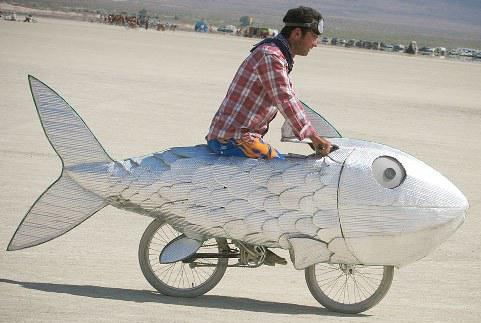

(323, 481, 3)


In [13]:
resized = 640, 640
img = PIL.Image.open(caffe_root + '/images/fish-bike.jpg')
img.thumbnail(resized, PIL.Image.ANTIALIAS)
img = np.float32(img)
showarray(img)
print np.shape(img)

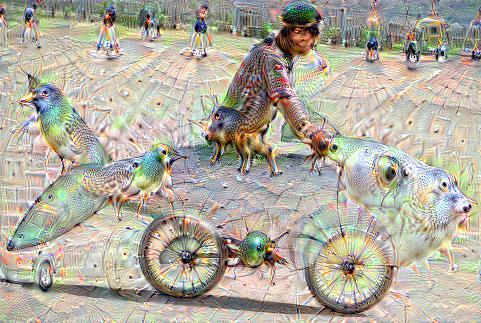

(octave: 0, iter: 199) , output: inception_4c/output , oct shape: (323,481,3) , loss: 4764.579045


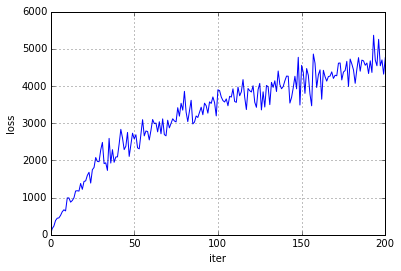

In [22]:
_,Loss=deepdream(net, img, iter_n= 200, octave_n = 1, end='inception_4c/output')

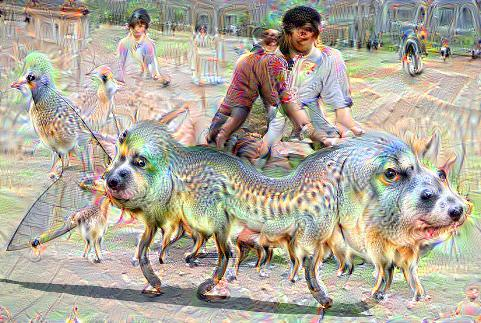

(octave: 3, iter: 68) , output: inception_4c/output , oct shape: (323,481,3) , loss: 4194.947822


In [91]:
_,L=deepdream(net, img, iter_n=69, end='inception_4c/output')

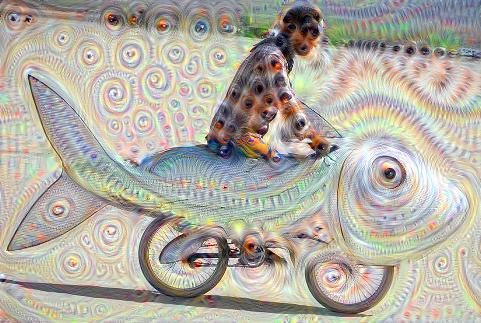

3 14 inception_3b/output (323, 481, 3) 1037.65877778


In [27]:
_=deepdream(net, img, iter_n=15, end='inception_3b/output')

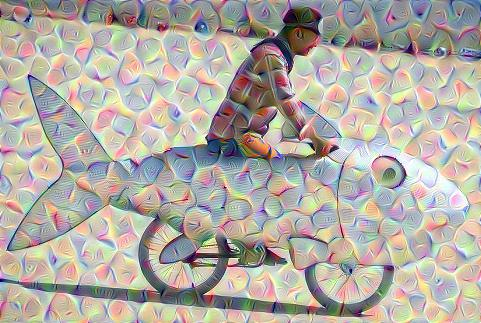

3 14 pool2/3x3_s2 (323, 481, 3) 2622.625


In [28]:
_,L=deepdream(net, img, iter_n=15, end='pool2/3x3_s2')

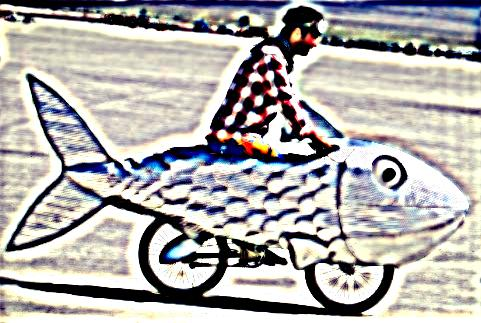

3 14 conv1/7x7_s2 (323, 481, 3) 54712.0659802


In [29]:
_,L=deepdream(net, img, iter_n=15, end='conv1/7x7_s2')

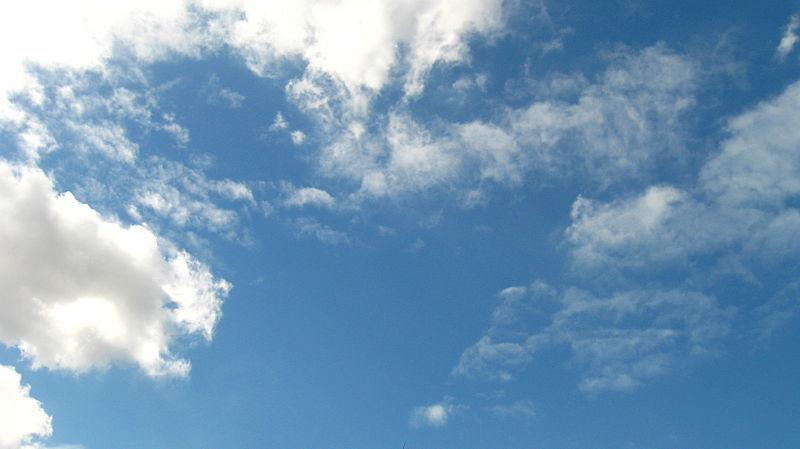

In [31]:
img = np.float32(PIL.Image.open('cloud.jpg'))
showarray(img)

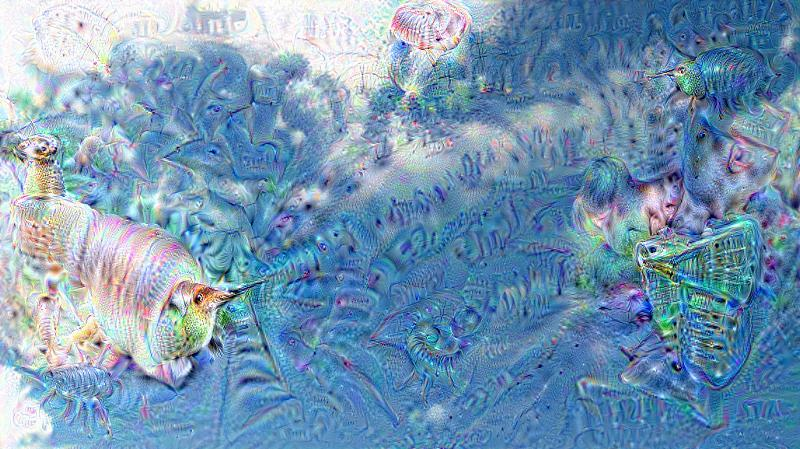

octave: 3, iter: 49) output: inception_5b/output oct shape: (449,800,3)  loss: 53.752985


In [37]:
_=deepdream(net, img, iter_n=50, end='inception_5b/output')

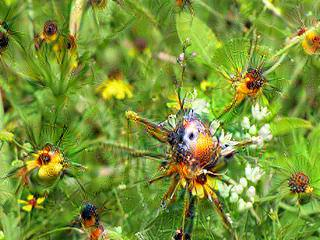

3 14 inception_4c/output (240, 320, 3)


In [27]:
_=deepdream(net, img, iter_n=15, end='inception_4c/output')

In [25]:
!mkdir frames
frame = img
frame_i = 0

mkdir: frames: File exists


In [26]:

h, w = frame.shape[:2]
s = 0.05
for i in xrange(100):
    frame = deepdream(net, frame)
    PIL.Image.fromarray(np.uint8(frame)).save("frames/%04d.jpg"%frame_i)
    frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1

KeyboardInterrupt: 